In [0]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from random import shuffle
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
from keras.callbacks import History
from keras.models import Sequential

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
TRAIN_DIR = "/content/drive/My Drive/traindata"
VAL_DIR = "/content/drive/My Drive/validation"
TEST_DIR = "/content/drive/My Drive/testdata"

IMG_SIZE = 50
LR = 1e-3

train_data_name = 'train_dvs_data.npy'
test_data_name = 'test_dvs_data.npy'
val_data_name = 'val_dvs_data.npy'
MODEL_NAME ="DVS-{}-{}.model".format(LR,'2dconv')

In [0]:
path = os.path.dirname(os.path.realpath('__file__'))
train_dir = os.path.join(path,TRAIN_DIR)
test_dir = os.path.join(path,TEST_DIR)
val_dir = os.path.join(path,VAL_DIR)

In [0]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog' : return [0,1]

In [0]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [0]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [0]:
def make_validation_data():
  validation_data = []
  for img in tqdm(os.listdir(VAL_DIR)):
        label = label_img(img)
        path = os.path.join(VAL_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        validation_data.append([np.array(img),np.array(label)])
  shuffle(validation_data)
  np.save('val_data.npy', validation_data)
  return validation_data

In [0]:
tf.reset_default_graph()
#convnet = Sequential()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5,activation = 'relu')
#convnet.add(LeakyReLU())
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5,activation = 'relu')
#convnet.add(LeakyReLU())
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5,activation = 'relu')
#convnet.add(LeakyReLU())
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5,activation = 'relu')
#convnet.add(LeakyReLU())
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5,activation = 'relu')
#convnet.add(LeakyReLU())
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024,activation = 'relu')
#convnet.add(LeakyReLU())
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log',best_val_accuracy='0.6')

training_data = create_train_data()
val_data = make_validation_data()
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = training_data
test = val_data

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

#history = History()

model.fit({'input': X}, {'targets': Y}, n_epoch=30, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

#temp = history.history['val_acc']
#best = 0
#if temp > MODEL_NAME[history.history[3]]:
#  temp = MODEL_NAME[history.history[3]]
#  best = MODEL_NAME
  
model.save(MODEL_NAME)
  



Training Step: 211  | total loss: 0.26955 | time: 0.381s
| Adam | epoch: 001 | loss: 0.26955 - acc: 0.9352 -- iter: 064/100


KeyboardInterrupt: ignored

100%|██████████| 30/30 [00:00<00:00, 308.20it/s]


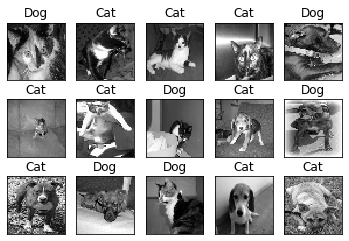

In [0]:
fig=plt.figure()
testing_data = process_test_data()
for num,data in enumerate(testing_data[15:30]):
    # cat: [1,0] dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
      str_label='Dog'
    else: 
      str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()